## Parte 2
Por el contrario en este dataset ya se proporciona una serie temporal, donde el objetivo es predecir el consumo de demnada eléctrico en Australia. Con esta serie temporal, si pueden aplicar las funciones de preparación de datos para CNN como se vió en clase.

In [1]:
import os
import pandas as pd

In [2]:

folder_path = "data/australia"

# Obtener lista de archivos CSV en la carpeta
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Leer y concatenar todos los CSV
df_list = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]
df_concatenado = pd.concat(df_list, ignore_index=True)

# Guardar el resultado en un nuevo archivo CSV
df_concatenado.to_csv(os.path.join(folder_path, "csv_concatenado.csv"), index=False)

print(f"Se han concatenado {len(csv_files)} archivos en 'csv_concatenado.csv'")


Se han concatenado 66 archivos en 'csv_concatenado.csv'


In [3]:
df1 = pd.read_csv("data/australia/csv_concatenado.csv")
df1

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2022/07/01 00:05:00,8656.59,396.62,TRADE
1,NSW1,2022/07/01 00:10:00,8539.53,380.41,TRADE
2,NSW1,2022/07/01 00:15:00,8591.66,380.41,TRADE
3,NSW1,2022/07/01 00:20:00,8601.76,380.41,TRADE
4,NSW1,2022/07/01 00:25:00,8518.26,371.29,TRADE
...,...,...,...,...,...
248587,NSW1,2020/04/30 22:00:00,7823.41,21.76,TRADE
248588,NSW1,2020/04/30 22:30:00,7850.90,27.91,TRADE
248589,NSW1,2020/04/30 23:00:00,7696.18,28.33,TRADE
248590,NSW1,2020/04/30 23:30:00,7623.36,41.96,TRADE


Aqui se tiene que hacer un truquito por como estan guardadas las fechas.

In [4]:
# Reemplazar las barras '/' por guiones '-'
df1['SETTLEMENTDATE'] = df1['SETTLEMENTDATE'].str.replace('-', '/', regex=True)
df1

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2022/07/01 00:05:00,8656.59,396.62,TRADE
1,NSW1,2022/07/01 00:10:00,8539.53,380.41,TRADE
2,NSW1,2022/07/01 00:15:00,8591.66,380.41,TRADE
3,NSW1,2022/07/01 00:20:00,8601.76,380.41,TRADE
4,NSW1,2022/07/01 00:25:00,8518.26,371.29,TRADE
...,...,...,...,...,...
248587,NSW1,2020/04/30 22:00:00,7823.41,21.76,TRADE
248588,NSW1,2020/04/30 22:30:00,7850.90,27.91,TRADE
248589,NSW1,2020/04/30 23:00:00,7696.18,28.33,TRADE
248590,NSW1,2020/04/30 23:30:00,7623.36,41.96,TRADE


In [5]:

df1 = df1.sort_values(by='SETTLEMENTDATE', ignore_index=True)
df1.dtypes

REGION             object
SETTLEMENTDATE     object
TOTALDEMAND       float64
RRP               float64
PERIODTYPE         object
dtype: object

In [6]:
df1["REGION"].unique()
df1 = df1.drop(columns=["REGION"], axis=1)
df1

,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,2018/01/01 00:30:00,6912.25,91.86,TRADE
1,2018/01/01 01:00:00,6745.63,88.83,TRADE
2,2018/01/01 01:30:00,6466.06,73.62,TRADE
3,2018/01/01 02:00:00,6279.80,71.49,TRADE
4,2018/01/01 02:30:00,6177.31,69.27,TRADE
...,...,...,...,...
248587,2023/06/27 23:40:00,8536.43,116.99,TRADE
248588,2023/06/27 23:45:00,8527.02,89.00,TRADE
248589,2023/06/27 23:50:00,8489.29,88.88,TRADE
248590,2023/06/27 23:55:00,8358.07,61.74,TRADE


In [7]:
df1["PERIODTYPE"].unique()
df1 = df1.drop(columns=["PERIODTYPE"], axis=1)
df1

,SETTLEMENTDATE,TOTALDEMAND,RRP
0,2018/01/01 00:30:00,6912.25,91.86
1,2018/01/01 01:00:00,6745.63,88.83
2,2018/01/01 01:30:00,6466.06,73.62
3,2018/01/01 02:00:00,6279.80,71.49
4,2018/01/01 02:30:00,6177.31,69.27
...,...,...,...
248587,2023/06/27 23:40:00,8536.43,116.99
248588,2023/06/27 23:45:00,8527.02,89.00
248589,2023/06/27 23:50:00,8489.29,88.88
248590,2023/06/27 23:55:00,8358.07,61.74


In [8]:
df1.isnull().sum()

SETTLEMENTDATE    0
TOTALDEMAND       0
RRP               0
dtype: int64

In [51]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler

In [11]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
n_steps = 3 #numero de pasos de tiempo
sequence = df1['TOTALDEMAND'].values
X, y = split_sequence(sequence, n_steps)
print('X', X, 'y', y, sep='\n')


X
[[6912.25 6745.63 6466.06]
 [6745.63 6466.06 6279.8 ]
 [6466.06 6279.8  6177.31]
 ...
 [8441.95 8536.43 8527.02]
 [8536.43 8527.02 8489.29]
 [8527.02 8489.29 8358.07]]
y
[6279.8  6177.31 6050.43 ... 8489.29 8358.07 8394.93]


In [14]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [28]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model1 = Sequential([
    keras.layers.Input(shape=(n_steps,)),
    Dense(units=128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(1)
])

# Compile the model with a different optimizer and learning rate
optimizer = Adam(learning_rate=0.01)
model1.compile(optimizer=optimizer, loss='mae', metrics=[tf.metrics.mape, tf.metrics.mse])

# Summarize the model
model1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,649 (45.50 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
# Ajustemos nuestro modelo compilado
history1 = model1.fit(X, y, epochs=50, verbose=True)

Epoch 1/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 437us/step - loss: 974.9400 - mean_absolute_percentage_error: 12.9527 - mean_squared_error: 3911806.7500
Epoch 2/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step - loss: 443.5542 - mean_absolute_percentage_error: 5.8086 - mean_squared_error: 323953.0000
Epoch 3/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 3s 428us/step - loss: 402.6062 - mean_absolute_percentage_error: 5.2695 - mean_squared_error: 270821.9375
Epoch 4/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 3s 423us/step - loss: 309.7289 - mean_absolute_percentage_error: 4.0398 - mean_squared_error: 167656.2188
Epoch 5/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step - loss: 293.1804 - mean_absolute_percentage_error: 3.8209 - mean_squared_error: 152206.6875
Epoch 6/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step - loss: 290.5726 - mean_absolute_percentage_error: 3.7942 - mean_squared_error: 149148.6406
Epoch 7/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 3s 423us/step - loss: 285.1227 - mean_absolute_percentage_error: 3.7

<Axes: >

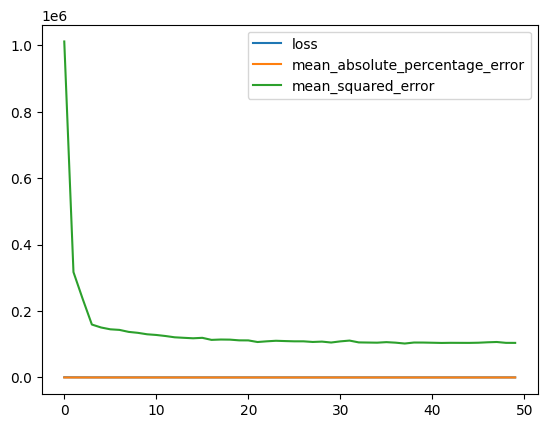

In [30]:
# Analizar función de pérdida
pd.DataFrame(history1.history).plot()

In [ ]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


1554/1554 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step


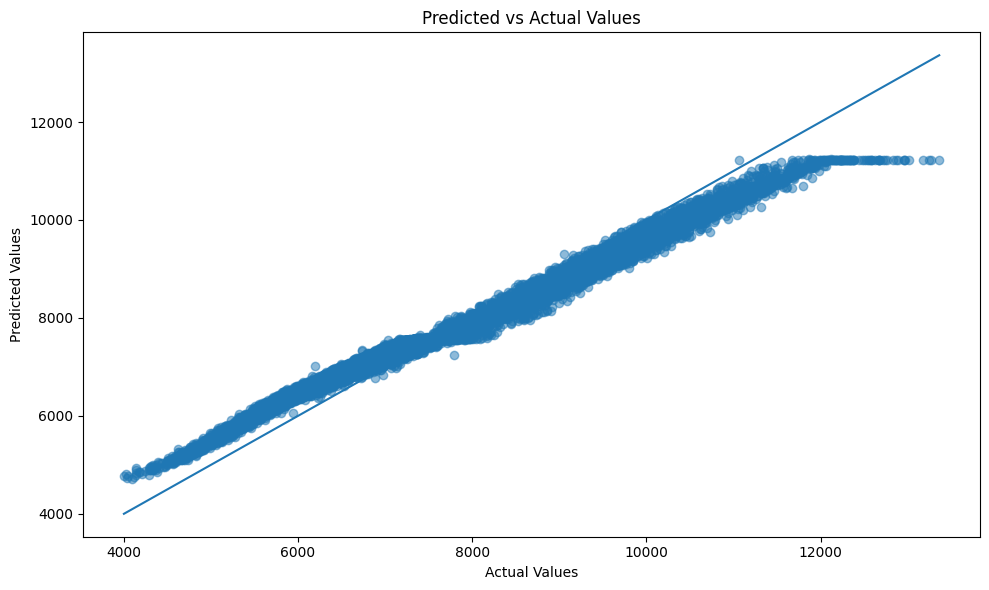

In [47]:
# Make predictions on validation set
y_pred = model1.predict(X_val)

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.tight_layout()
plt.show()

Mean Absolute Error: 271.7520
R² Score: 0.9377


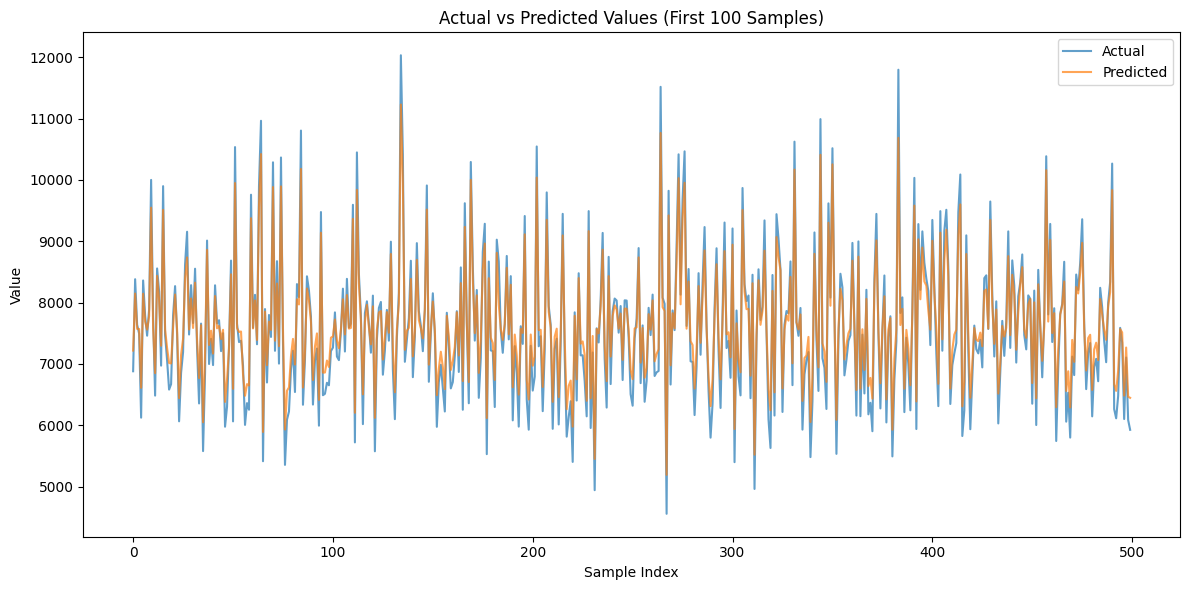

In [49]:
# Calculate and print some error metrics
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'R² Score: {r2:.4f}')

# Plot a sample of predictions vs actual values
plt.figure(figsize=(12, 6))
sample_size = 500
plt.plot(y_val[:sample_size], label='Actual', alpha=0.7)
plt.plot(y_pred[:sample_size], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


# 2 Modelo multivariado

In [50]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence(sequence: np.ndarray, n_steps: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps
        
        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [74]:
features = df1[['TOTALDEMAND', 'RRP']].values

# Define the sequence
n_steps = 3
X, y = split_multivariate_sequence(features, n_steps)




In [75]:
from tensorflow.keras.layers import LSTM, Dense

In [76]:
# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, X.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["mean_absolute_error"])

# Train the model
model.fit(X, y, epochs=50, verbose=1)

# Model summary
model.summary()

Epoch 1/50


/Users/maripau/Desktop/ITESO/No lineales/noLinealesVenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7769/7769 ━━━━━━━━━━━━━━━━━━━━ 5s 559us/step - loss: 78312.1406 - mean_absolute_error: 84.5916
Epoch 2/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 564us/step - loss: 85419.8828 - mean_absolute_error: 83.2297
Epoch 3/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 574us/step - loss: 89447.5625 - mean_absolute_error: 83.0454
Epoch 4/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 568us/step - loss: 95991.4531 - mean_absolute_error: 83.8154
Epoch 5/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 567us/step - loss: 82427.8438 - mean_absolute_error: 81.9330
Epoch 6/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 562us/step - loss: 83206.8359 - mean_absolute_error: 81.6718
Epoch 7/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 562us/step - loss: 78488.3047 - mean_absolute_error: 81.5279
Epoch 8/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 570us/step - loss: 75213.9297 - mean_absolute_error: 80.2249
Epoch 9/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 561us/step - loss: 76718.1484 - mean_absolute_error: 80.8176
Epoch 10/50
7769/7769 ━━━━━━━━━━━━━━━━━━━━ 4s 567us/step 

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,105 (137.13 KB)

 Trainable params: 11,701 (45.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,404 (91.43 KB)

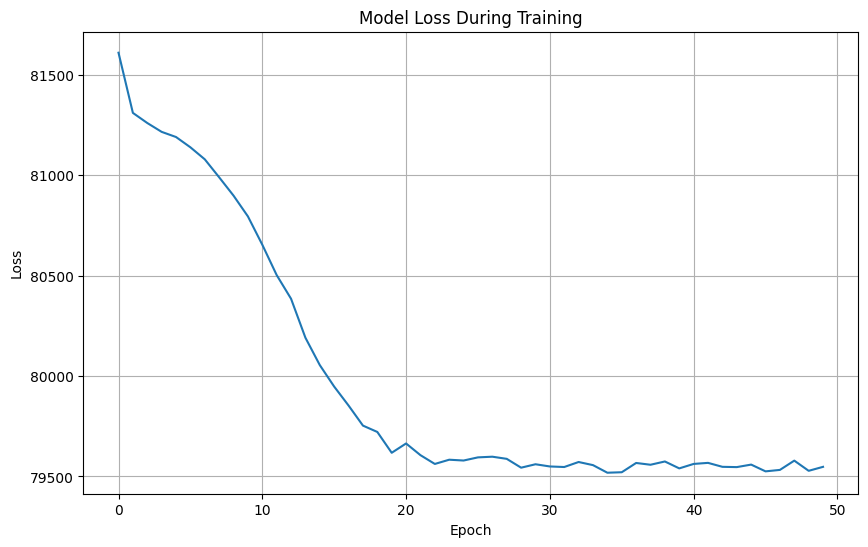

In [77]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(model.history.history['loss'])
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


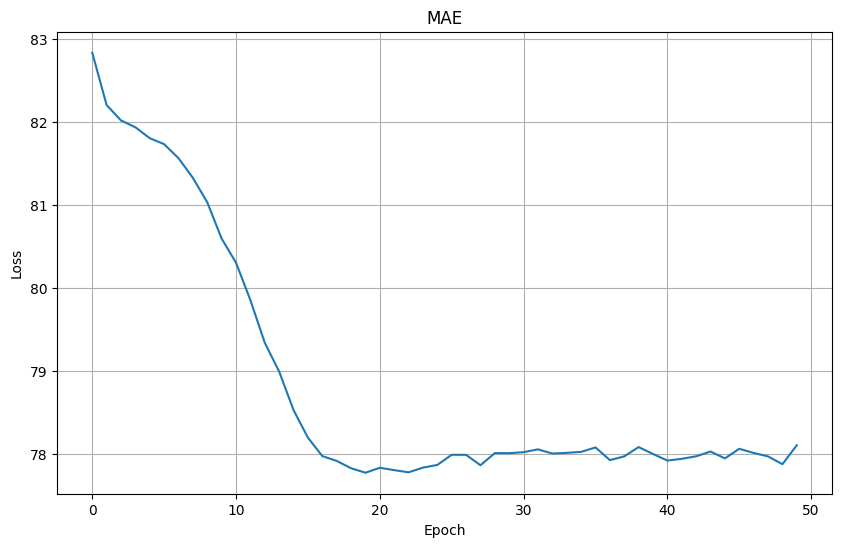

In [78]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(model.history.history['mean_absolute_error'])
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


7769/7769 ━━━━━━━━━━━━━━━━━━━━ 2s 269us/step


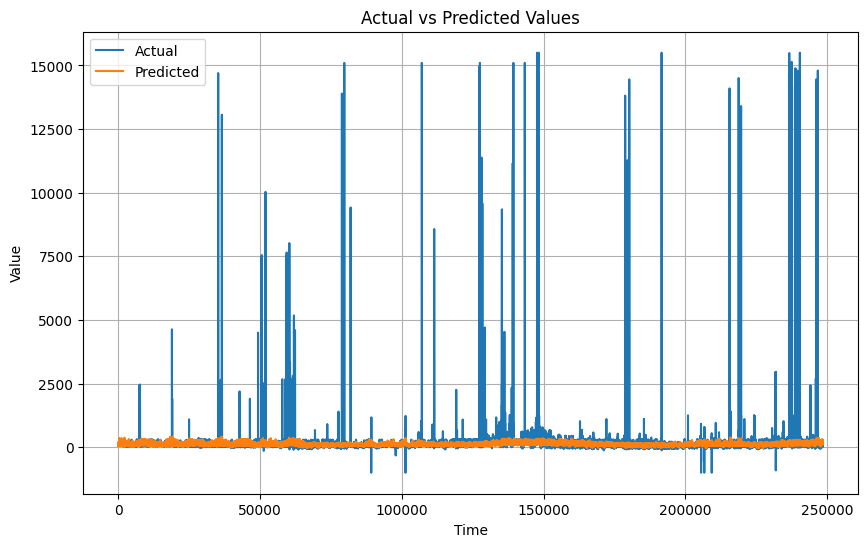

In [79]:
# Make predictions
predictions = model.predict(X)

# Flatten predictions and actual values
predictions_flat = predictions.reshape(-1)
y_flat = y.reshape(-1)
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_flat, label='Actual')
plt.plot(predictions_flat, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
